# **2 Grouping customers together!**

In [96]:
import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
from datetime import datetime
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets import load_iris
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## **2.1 Getting your data + feature engineering**

### **2.2.1 Loading the dataset**

* Let's start the work with this dataset! "Bank Customer Segmentation (1M+ Transactions)" contain informations about banking transactions in India in 2016.

In [14]:
data = pd.read_csv(r"bank_transactions.csv")

#### **Inside the dataset**

In [15]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [7]:
data.shape

(1048567, 9)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


* Our analysis will study the groups of clients which are similar among them. From the informations of the dataset we look that there are 1048567 transactions and 9 variables:

  1. `TransactionID` - number (ID) of the transaction (object)

  2. `CustomerID` - number (ID) of the costumer (object)

  3. `CustomerDOB` - customer date of birth (object)

  4. `CustGender`  - customer's gender (object)

  5. `CustLocation` - location - (object)

  6. `CustAccountBalance` - account balance (float64)

  7. `TransactionDate` - day of the transaction (object)

  8. `TransactionTime` - time of the transaction(int64)

  9. `TransactionAmount (INR)` - amount of the transaction in INR (float64) 

The first problem that we encounter is that the `customerDOB` and the `transactionDate` are not in the datetime form; instead `TransactionTime` is just a number and we need to transform it in datetime. To solve this and check the other problem we begin with a feature engineering in our dataset: `data`

### **2.1.2 Feature Engineering in data**

#### **Features: CustomerDOB, transactionDate, TransactionTime**

* The first features that we analyse are `CustomerDOB`, `TransactionDate` and `TransactionTime`. This features need to be in datetime form.

In [16]:
data.CustomerDOB = pd.to_datetime(data["CustomerDOB"], format='%d/%m/%y',errors='coerce')
data.TransactionDate = pd.to_datetime(data["TransactionDate"], format='%d/%m/%y',errors='coerce')
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

* Now that the 3 variables with problems in dtype are in the correct form let's have a look inside the data to see if the transformation create problems and if there are strange data.

<AxesSubplot:>

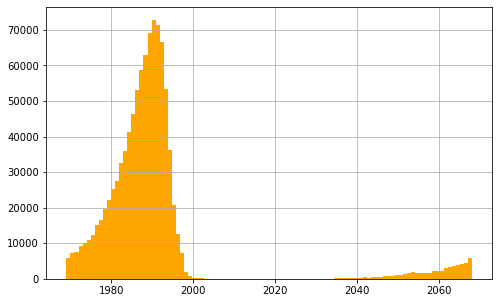

In [323]:
data.CustomerDOB.dt.year.hist(bins=100, color = "orange")

* Looking into the histogram it's visible the majority of the distribution in the left block.<br>  The block to the right contains the customers' date of birth which fall around the year 2060.This happened because changing the dtype from object to datetime we collide in the *millennium bag*: the years in object are saved with just the last 2 numbers (for example 1950 is saved as 50), so the transformation creates problems because some dates will be saved as 1950 others in 2050. To solve this problem we subtract 100 to the years that come after the year 2005 (so after the end of the central block). Infact to open a bank account in India it's necessary to have at least 10 years, so there cannot be customers born after the year 2005.

<AxesSubplot:>

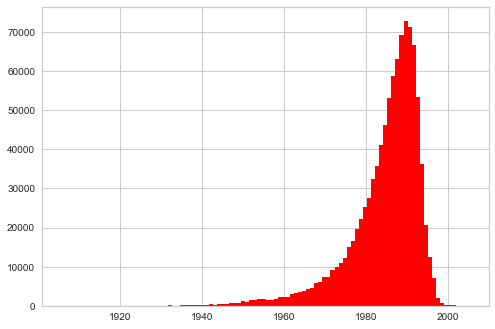

In [17]:
data.loc[data.CustomerDOB.dt.year > 2005, "CustomerDOB"] = data.loc[data.CustomerDOB.dt.year > 2005, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.CustomerDOB.dt.year.hist(bins=100, color = "red")

In [18]:
data.CustomerDOB.dt.year.agg(lambda x: pd.Series.mode(x))

0    1990.0
Name: CustomerDOB, dtype: float64

* Now it's visible in the histogram the right distribution of the customers' date of birth, with a peak of 72789 birthdays in 1990.

In [326]:
data.CustomerDOB.dt.year.value_counts()

1990.0    72789
1991.0    71288
1989.0    69238
1992.0    66708
1988.0    63004
          ...  
1920.0        2
1911.0        2
1916.0        2
1925.0        1
1918.0        1
Name: CustomerDOB, Length: 99, dtype: int64

#### **NA values**

* Let's have a look if in the dataset there are some missing values or some false values that need to be drop.

In [327]:
data.isna().sum()

TransactionID                  0
CustomerID                     0
CustomerDOB                60736
CustGender                  1100
CustLocation                 151
CustAccountBalance          2369
TransactionDate                0
TransactionTime                0
TransactionAmount (INR)        0
dtype: int64

* The number of values that is NA concerns 4 variables (`customerDOB`, `custGender`, `custLocation`, `CustAccountBalance`), anyway their number is very small compare to the amount of data that we own (1048567 transactions) so we delete this data.

In [19]:
data.dropna(inplace = True)

In [20]:
data.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

#### **CustGender**

In [330]:
data['CustGender'].value_counts()

M    712454
F    272868
Name: CustGender, dtype: int64

* The Customer's gender can be Male or Female.

#### **TransactionAmount (INR)**

* To semplify the code we change the column name of the variable `TransactionAmount (INR)` in `TransactionAmount`.

In [21]:
data.rename(columns = {'TransactionAmount (INR)':'TransactionAmount'}, inplace = True)

#### **Duplicated**

In [22]:
data[data.duplicated()]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount


* There are no duplicated data, so it's possible to say that the dataset is *clean*.

In [333]:
data.shape

(985322, 9)

* The number of transactions now are in total 985322 with 9 variables.

## **EDA: Exploratory data analysis**

In [334]:
round(data.describe(),1)

,CustAccountBalance,TransactionAmount
count,985322.0,985322.0
mean,106061.2,1452.4
std,817905.4,6139.8
min,0.0,0.0
25%,4582.1,151.0
50%,16006.3,431.0
75%,53759.1,1125.0
max,115035495.1,1560035.0


#### DA FARE EDA

### **2.1.3 Feature Engineering in Clients dataset**

* To begin the *Feature Engineering* we create a new dataset where to put all the new variables created considering the clients.

In [23]:
clients = pd.DataFrame()

* It's time now to create the variables:
1. Number of transactions:

In [24]:
numero_transazioni = data.groupby(['CustomerID'])["TransactionID"].count()
clients["Num_transaction"]=numero_transazioni

2. Number of transactions with a balance bigger than 100 USD (converteing the INR in USD):

In [25]:
data.loc[data.TransactionAmount*0.012 <= 100, 'Transaction>100USD'] = 0
data.loc[data.TransactionAmount*0.012 > 100, 'Transaction>100USD'] = 1
clients["Transaction>100USD"] = data.groupby('CustomerID')['Transaction>100USD'].sum()

3. Average amount of the transactions:

In [26]:
clients["Average_transaction"]= data.groupby('CustomerID')['TransactionAmount'].mean()

4. Average balance:

In [27]:
clients["Average_balance"]= data.groupby('CustomerID')['CustAccountBalance'].mean()

5. Utilisation (Average difference between the balance and the transaction amount for each customer):

In [28]:
data["difference"]= data['CustAccountBalance']-data['TransactionAmount']
clients["Utilisation"]= data.groupby('CustomerID')['difference'].mean()

6. Most common gender of the customer:

In [29]:
data.loc[data.CustGender == "M", 'GenderNum'] = 0
data.loc[data.CustGender == "F", 'GenderNum'] = 1
clients["GenderNum"]= data.groupby('CustomerID')['GenderNum'].sum()
clients.loc[clients.GenderNum > clients.Num_transaction/2, 'Gender'] = "F"
clients.loc[clients.GenderNum < clients.Num_transaction/2, 'Gender'] = "M"
clients.loc[clients.GenderNum == clients.Num_transaction/2, 'Gender'] = random.choice(["M", "F"])
clients.drop('GenderNum', inplace=True, axis=1)
data.drop('GenderNum', inplace=True, axis=1)

7. Most frequent location of the customer:

In [30]:
location = data.groupby(['CustomerID'])['CustLocation'].agg(pd.Series.mode)
lista=[]
for i in location.index:
    if type(location.loc[i]) == str:
        lista.append(location[i])
    else:
        lista.append(location[i][0])
clients["Location"]=lista

###  **2.1.3 NEW FEATURES**

* We are going to create 20 new features, to give more details about the dataset's information:

1) Total Transactions: the sum of all the transaction for a client.

In [31]:
clients["Total_transactions"]= data.groupby('CustomerID')['TransactionAmount'].sum()

2) Max transaction: the maximum value for a client's transaction.

In [32]:
clients["Max_transaction"]= data.groupby('CustomerID')['TransactionAmount'].max()

3) Min transaction:  the minimum value for a client's transaction.

In [33]:
clients["Min_transaction"]= data.groupby('CustomerID')['TransactionAmount'].min()

4) Max balance:  the maximum value for a client's balance.

In [34]:
clients["Max_balance"]= data.groupby('CustomerID')['CustAccountBalance'].max()

5) Min balance: the minimum value for a client's balance.

In [35]:
clients["Min_balance"]= data.groupby('CustomerID')['CustAccountBalance'].min()

6) Max Utilisation: the maximum utilisation value for a client ( difference between the balance and the transaction amount).

In [36]:
clients["Max_Utilisation"]= data.groupby('CustomerID')['difference'].max()

7) Min Utilisation: the minimum utilisation value for a client ( difference between the balance and the transaction amount).

In [37]:
clients["Min_Utilisation"]= data.groupby('CustomerID')['difference'].min()

8)  Transaction > 100: Number of transaction bigger than 100 INR.

In [38]:
data.loc[data.TransactionAmount <= 100, 'Transaction>100'] = 0
data.loc[data.TransactionAmount > 100, 'Transaction>100'] = 1
clients["Transaction>100"] = data.groupby('CustomerID')['Transaction>100'].sum()

9) Balance>10000: Number of times between every transaction that the balance is bigger than 10000 INR.

In [39]:
data.loc[data.CustAccountBalance <= 10000, 'Balance>10000'] = 0
data.loc[data.CustAccountBalance > 10000, 'Balance>10000'] = 1
clients["Balance>10000"] = data.groupby('CustomerID')['Balance>10000'].sum()

10) Utilisation<1000: Number ot times that utilisation is less than 1000.

In [40]:
data.loc[data.difference < 1000, 'Utilisation>1000'] = 0
data.loc[data.difference >= 1000, 'Utilisation<1000'] = 1
clients["Utilisation<1000"] = data.groupby('CustomerID')['Utilisation<1000'].sum()

11) Percentage of transaction > 100 on the total:

In [41]:
clients["%transaction>100"] = (clients["Transaction>100"]/clients["Num_transaction"]*100).round(2)

12) Percentage of Balance > 10000 on the total:

In [42]:
clients["%Balance>10000"] = (clients["Balance>10000"]/clients["Num_transaction"]*100).round(2)

13) Percentage of Utilisation < 1000 on the total:

In [43]:
clients["%Utilisation<1000"] = (clients["Utilisation<1000"]/clients["Num_transaction"]*100).round(2)

14) Most common day for transactions:

In [44]:
data['Day'] = data.TransactionDate.dt.dayofweek
data.Day =  data.Day.astype(str)
day = data.groupby(['CustomerID'])['Day'].agg(pd.Series.mode)
lista=[]
for i in day.index:
    if type(day.loc[i]) == str:
        lista.append(day[i])
    else:
        lista.append(day[i][0])
clients["Day"] = lista

15) most common month for transactions:

In [45]:
data['Month'] = data['TransactionDate'].dt.month
data.Month =  data.Month.astype(str)
month = data.groupby(['CustomerID'])['Month'].agg(pd.Series.mode)
lista=[]
for i in month.index:
    if type(month.loc[i]) == str:
        lista.append(month[i])
    else:
        lista.append(month[i][0])
clients["Month"] = lista

16) Time of the day with more transactions:

In [46]:
data['Hour'] = data['TransactionTime'].dt.hour
data.Hour =  data.Hour.astype(str)
hour = data.groupby(['CustomerID'])['Hour'].agg(pd.Series.mode)
lista=[]
for i in hour.index:
    if type(hour.loc[i]) == str:
        lista.append(hour[i])
    else:
        lista.append(hour[i][0])
clients["Hour"] = lista

17) Time since the first and last transaction in days:

In [47]:
data["time(day)"] = pd.to_datetime('today') - data.TransactionDate
clients["dist_minimum"] = data.groupby('CustomerID')['time(day)'].min()
clients["dist_maximum"] = data.groupby('CustomerID')['time(day)'].max()
clients["Time(day)"] = clients["dist_maximum"] - clients["dist_minimum"]
clients["Time(day)"] = clients["Time(day)"].dt.days
clients.drop('dist_minimum', inplace=True, axis=1)
clients.drop('dist_maximum', inplace=True, axis=1)

18) Costumer age Max (in the year 2016, year to which the payment have been done. we are going to take the max value and so the oldest person for each bank account):

In [48]:
data['CustomerAge'] = 2016 - data.CustomerDOB.dt.year
clients["CustomerAge_max"] = data.groupby('CustomerID')['CustomerAge'].max()

19) Costumer age Min (in the year 2016, year to which the payment have been done. we are going to take the min value: the age of the youngest person of each bank account):

In [49]:
clients["CustomerAge_min"] = data.groupby('CustomerID')['CustomerAge'].min()

20) Rich Customer: Is the average_balance >10000 and the transaction been made in one of the ricchest city in India? (Mumbai, New Delhi, Delhi, ):

In [50]:
clients.loc[(((clients.Location == "MUMBAI") | (clients.Location == "NEW DELHI") | (clients.Location == "DELHI")) & (clients["Average_balance"]>10000)), 'RichCustomer'] = "Yes"
clients.loc[((((clients.Location == "MUMBAI") | (clients.Location == "NEW DELHI") | (clients.Location == "DELHI")) & (clients["Average_balance"]<= 10000)) | ((clients.Location != "MUMBAI") & (clients.Location != "NEW DELHI") & (clients.Location != "DELHI"))), 'RichCustomer'] = "No"

In [378]:
clients.head()

,Num_transaction,Transaction>100USD,Average_transaction,Average_balance,Utilisation,Gender,Location,Total_transactions,Max_transaction,Min_transaction,...,%transaction>100,%Balance>10000,%Utilisation<1000,Day,Month,Hour,Time(day),CustomerAge_max,CustomerAge_min,RichCustomer
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,0.0,2553.0,76340.635,73787.635,M,NEW DELHI,5106.0,4750.0,356.0,...,100.0,100.0,100.0,0,8,1,48,33,24,Yes
C1010012,1,0.0,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,1499.0,...,100.0,100.0,100.0,6,8,20,0,22,22,Yes
C1010014,2,0.0,727.5,100112.950,99385.450,M,MUMBAI,1455.0,1205.0,250.0,...,100.0,100.0,100.0,0,8,15,6,32,24,Yes
C1010018,1,0.0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,30.0,...,0.0,0.0,0.0,3,9,17,0,26,26,No
C1010024,1,0.0,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,5000.0,...,100.0,100.0,100.0,3,8,14,0,51,51,No


In [390]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 839081 entries, C1010011 to C9099956
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Num_transaction      839081 non-null  int64  
 1   Transaction>100USD   839081 non-null  float64
 2   Average_transaction  839081 non-null  float64
 3   Average_balance      839081 non-null  float64
 4   Utilisation          839081 non-null  float64
 5   Gender               839081 non-null  object 
 6   Location             839081 non-null  object 
 7   Total_transactions   839081 non-null  float64
 8   Max_transaction      839081 non-null  float64
 9   Min_transaction      839081 non-null  float64
 10  Max_balance          839081 non-null  float64
 11  Min_balance          839081 non-null  float64
 12  Max_Utilisation      839081 non-null  float64
 13  Min_Utilisation      839081 non-null  float64
 14  Transaction>100      839081 non-null  float64
 15  Balance>10000

#### **Let's save the dataset!**

In [379]:
clients.to_pickle("bank.pkl")

## **2.2 Choose your features (variables)!**

* Our `clients` dataset is now full of variables. There are as many as 27 of them, so it becomes very difficult to carry out analysis, create efficient visualization, and work quickly with this kind of dataset.<br> For this reason we will carry out *dimensionality reduction*: we reduce our number of variables without exaggeratedly reducing the information contained in them. Before carrying out this procedure, however, we address some problems.<

* You can perform dimensional reduction by many different methods. The method we will apply in our case will be the **Principal Component Analysis**. <br>This method makes it possible to merge variables that are highly correlated with each other. Doing so will result in fewer variables that still contain a lot of information. In order for the dataset to be representative, the total variance of the principal components must be greater than 70%.<br> Fewer principal components means easier to work with and visualize data but also means less information. A higher number of principal components, on the other hand, means more information but less efficiency in work. The *"game"* will then be to choose the number of principal components just above 70% total explained variability.<br> It is possible to use only quantitative variables in **PCA**. Accordingly, we will not use the variables `Gender`, `Location`, `Day`, `Month`, `Hour` and `RichCustomer`. Anyway, it will be possible to incorporate them as target variables later if they bring effective characterization into our analysis.

In [6]:
clients = pd.read_pickle("bank.pkl")

In [7]:
caratteristiche = ['Num_transaction', 'Transaction>100USD', 'Average_transaction',
       'Average_balance', 'Utilisation',
       'Total_transactions', 'Max_transaction', 'Min_transaction',
       'Max_balance', 'Min_balance', 'Max_Utilisation', 'Min_Utilisation',
       'Transaction>100', 'Balance>10000', 'Utilisation<1000',
       '%transaction>100', '%Balance>10000', '%Utilisation<1000', 'Time(day)', 'CustomerAge_max', 'CustomerAge_min']

In [8]:
clients_quant = clients[caratteristiche]

* As with all analyses based on *variance*, single *outliers* can affect the results especially if they are very extreme and if the sample size is low. So we start a fast check for *outliers*.

In [9]:
Q1 = clients_quant.quantile(0.05)
Q3 = clients_quant.quantile(0.95)
IQR = Q3 - Q1
clients_out = clients_quant[~((clients_quant < (Q1 - 1.5 * IQR)) |(clients_quant > (Q3 + 1.5 * IQR))).any(axis=1)]
clients_out = pd.DataFrame(clients_out)
print("Dataframe with outliers:",clients_quant.shape[0], "Dataframe without outliers:", clients_out.shape[0])
print("Outliers:",clients_quant.shape[0]- clients_out.shape[0])

Dataframe with outliers: 839081 Dataframe without outliers: 794956
Outliers: 44125


* We remove the 44125 outliers that are in the first 0.05 percentile and in the last 0.05 percentile. In this way we will remain with 794956 data and our Principal Components (**PC**) will be more precisly.<br> After that, the assumptions of Pearson's linear correlation index must be met. <br> Since the **PCA** is based on the pooled variance among variables, it makes sense to include in the model only variables that are at least *moderately correlated* with each other.<br> If a variable has correlation indices very close to 0 with all other variables (generally, a correlation between -0.3 and + 0.3 is considered weak), then that variable should not be included in the **PCA**.<br> This is because forcing that variable to merge with others will result in a very high loss of information, and this is a situation that is generally preferred to be avoided.

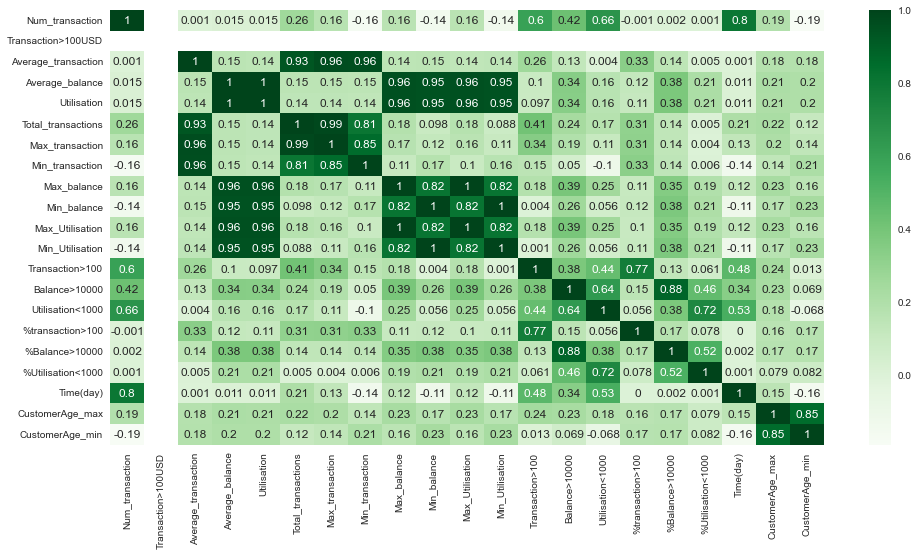

In [10]:
clients_corr = clients_out.corr()
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(18, 18))
df= df.iloc[: , [3,4,5,6,7,8,9,10,11,12,13,14,17]].copy()
plt.figure(figsize=(16,8))
sns.heatmap(round(clients_corr,3), cmap="Greens",annot=True)
plt.show()

In [11]:
caratteristiche2 = ['Num_transaction', 'Average_transaction',
       'Average_balance', 'Utilisation',
       'Total_transactions', 'Max_transaction', 'Min_transaction',
       'Max_balance', 'Min_balance', 'Max_Utilisation', 'Min_Utilisation',
       'Transaction>100', 'Balance>10000', 'Utilisation<1000',
       '%transaction>100', '%Balance>10000', '%Utilisation<1000', 'Time(day)', 'CustomerAge_max', 'CustomerAge_min']

In [12]:
clients_final = clients_out[caratteristiche2]

* Transaction>100USD have no more values, so we can remove it. All the other variables are correlated with each other so we are not going to exclude any of them from the model.<br> High numerosity of our sample is needed, at least 10 units for each variable, and we have it. So now all the conditions are acccepted.

In [58]:
print("Number of rows:", clients_final.shape[0])
print("Number of columns:", clients_final.shape[1])

Number of rows: 794956
Number of columns: 20


### **2.2.1 Standardization**

* Performing *standardization* is essential when you have variables of very different scales. For example, in our dataset the values of `num_transaction` and `average_transaction` or even `%transaction>100` are very different from each other. <br> *Standardization* adjusts the values to a common scale allowing them to be compared more easily, infact purpose of **PCA** is to find directions that maximizes the variance. If the variances of the variables are very different among them the higher variance will be more influent and the principal components will be biased in that direction. Instead with the standardization they will be all distributed around a mean of zero with a standard deviation of one. This allows each variable to have a similar influence on the model.<br> Normalization instead doesn't solve this problem.

In [13]:
scaler = StandardScaler()
clients_stand = scaler.fit_transform(clients_final)

In [14]:
clients_stand = pd.DataFrame(clients_stand, columns = caratteristiche2)

* Let's start now with the principal component analysis!

### **2.2.2 / 2.2.3 PCA for dimensionality reduction**

* The first thing to do is to choose how many principal components to take.<br> You can see how the amount of information increases as the number of principal components increases in the following graph.

In [66]:
pca5 = PCA(n_components=5)
principalComponents5 = pca5.fit_transform(clients_stand)
principalDf5 = pd.DataFrame(data = principalComponents5
             , columns = ['PC1', 'PC2','PC3','PC4','PC5'])

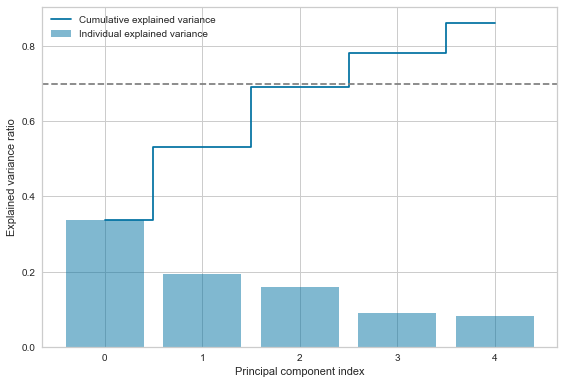

In [67]:
exp_var_pca = pca5.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axhline(y=0.70, color='grey', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

* Looking in to the graph is possible to visualize how much all the principal components say about the dataset's informations. The best number of principal components is 4. In fact 4 is the minimum number of **PC** to ensure at least 70% of variance. In fact:
   - the Total explained variance with 4 components is 78.02%, an high level of information, that allows us to reduce the dimensionality from 20 to 4; 
   - With 3 principal component, the level of total explained variance is 69,07%, which is insufficient to represent all the variability in the dataset since it is below the threshold of 70%; 
   - Choosing 5 or more principal components is not appropriate since 4 components are enough to tell the information well, and choosing 5 principal components brings an increase in information of 8,11% (and by increasing PCs the increase is vanishingly small) while moving away from our goal of dimensionality reduction.

In [15]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(clients_stand)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4'])
principalDf

,PC1,PC2,PC3,PC4
0,3.323678,5.000306,4.136805,2.067387
1,-0.138853,0.950463,-0.145977,-0.271783
2,2.256306,1.111607,3.402722,0.322776
3,-3.259487,-1.836603,-1.636101,1.712846
4,3.724301,4.906883,-3.414421,-2.067149
...,...,...,...,...
794951,1.605456,-1.108540,0.033150,-0.027328
794952,0.488501,-1.368010,0.598173,0.220145
794953,-1.993473,-0.616890,0.103797,0.663423
794954,-1.251523,-1.982719,0.551726,-0.354617


* Here it is our New dataset! `PrincipalDf`. This dataset collects all the principal componets coordinates for the data.<br> In the next rows there are the variances for all the 4 principal components to check how much any **PC** say about the original information and the total explained variance.

In [69]:
pca.explained_variance_ratio_
print("principal component 1 variance:", pca.explained_variance_ratio_[0].round(2),"%")
print("principal component 2 variance:", pca.explained_variance_ratio_[1].round(2),"%")
print("principal component 3 variance:", pca.explained_variance_ratio_[2].round(2),"%")
print("principal component 4 variance:", pca.explained_variance_ratio_[3].round(2),"%")

print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5), "%"  )

principal component 1 variance: 0.34 %
principal component 2 variance: 0.19 %
principal component 3 variance: 0.16 %
principal component 4 variance: 0.09 %
Components =  4 ;
Total explained variance =  0.78025 %


In [70]:
pca_comp = pd.DataFrame(data = pca.components_, 
                           columns = caratteristiche2, 
              index= ['PC1', 'PC2', 'PC3','PC4']) 
#pca_comp.T

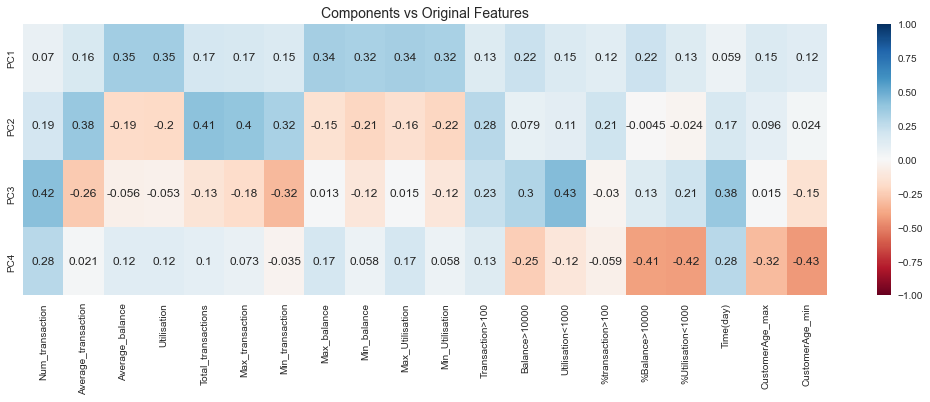

In [71]:
plt.figure(figsize=(18,5))
y_axis_labels = ["PC1", "PC2", "PC3", "PC4"]
x_axis_labels = caratteristiche2
ax = sns.heatmap(pca.components_,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True,
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels
            )
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

* In the table you can see how much each feature is correlated with the principal components. The closer the value is to 1 the more the variable is positively correlated with the principal component (if equal to 1 it is positively correlated perfectly), the closer the value is to -1 the more it is negatively correlated (if equal to -1 it is negatively correlated perfectly). On the other hand, if the value is close to zero then the variable is uncorrelated:
  - The first principal component is marked by a correlation more substantial of the balance and utilisation (average, min and max) In fact, holding the other variables stationary, increasing for example `Utilisation` by 1, the first principal component increases on average by 0.35;

  - The second principal component depends on average especially on variables that tell about transactions (Total, max, min, average). In fact, for example, holding the other variables stationary, increasing `total_transaction` by 1, the second principal component increases on average by 0.41;

  - The third PC is characterized in particulary by the number of transaction, utilisation<1000 and time(day);

  - While the forth principal component is negatively correlated by `%Balance>10000`, `%Utilisation<1000` and `CustomerAge_min`. This means that increasing `CustomerAge_min` by 1 and holding all the other variables stationary, the forth principal component decreases on average by 0.43.

* Anyway the features are not strongly correlated with any of the principal components, all the values of correlation correspond to less than 0.5 (absolute value).

## **2.3: Clustering!**

### **2.3.1: K-means clustering algorithm**

 
 +   There are three popular categories of clustering algorithms: Partitional clustering, Hierarchical clustering, Density-based clustering.<br> The **K-means** method is a partitional type. Thus, it is characterized by the fact that it divides data objects into non-overlapping clusters such that observations in one cluster are similar to each other and dissimilar to those in the remaining sets. The similarity between samples is used to shape the clusters, making sure that similar observations end up in the same set.<br> These techniques require the user to specify the number of clusters, moreover these algorithms are nondeterministic , meaning that they could produce different results from two separate runs even if the runs were based on the same input.

 
+   Partitional clustering methods have several **strengths** :
    1) They work well when clusters have a spherical shape.
    2) They are scalable with respect to the complexity of the algorithm.
    
    They also have several **weaknesses** :
    1) They are not suitable for clusters with complex shapes and different sizes.
    2) They break down when used with clusters of different densities.

+ More specific the **K-means** procedure needs $ k $ intial centroids, that are data points that represent the center of a cluster, where $k$ is equal to the number of clusters to be obtained.<br>The process consists of two steps called *expectation* and *maximization* . The expectation phase assigns each data point to the nearest centroid. Then, the maximization phase calculates the average of all points for each cluster and sets the new centroid.The expectation-maximization steps are repeated until all the data are assigned to a cluster .<br>The quality of the cluster assignments is determined by calculating the sum of squared error ($SSE$) relative to the final centroids. The $SSE$ is defined as the sum of the squared Euclidean distances of each point from its nearest centroid. Since this is a measure of error, the goal of K-mean is to try to minimize this value.

+ Here `K_means` is an implementation of the **K-Means** procedure, given the `initial_centroids` as a dataframe, it splits the `dataframe` in `n_chunk` chunks and analyzes them one by one; each point belonging to a chunck is associated with the nearest centroid, and before moving on to the next chunck the centroids are updated. This last step, however, is performed only if the distances between the updated centroids and the pevious ones exceeds a certain fixed threshold, qualitatively represented by the input parameter `tollerance`.

In [100]:
def K_means(dataframe, n_chunk, initial_centroids, tollerance):
    
    # WE INITIALIZE THE NUMBER OF CLUSTERS AND PRINCIPAL COMPONENTS
    k=initial_centroids.shape[0]
    num_PC=initial_centroids.shape[1]
    
    # WE INITIALIZE THE VARIABLE THAT WILL CONTAIN THE CURRENT CENTROIDS
    centroids = initial_centroids.copy(deep=True)
    
    # WE INITIALIZE THE DELIMITERS OF THE CHUNKS INTO WHICH THE DATAFRAME WILL BE DIVIDED 
    chunk_delimiters = np.linspace(0, dataframe.shape[0], num=(n_chunk +1), endpoint=True, dtype=int)
    
    # WE INITIALIZE SOME SUPPORT VARIABLES
    clusters_info = {'Sum':centroids.to_numpy(copy=True) , 'counter': np.ones((k,1), dtype=int),'stop_update': np.ones(k)}
    final_cluster=pd.Series(np.zeros(len(dataframe),dtype=int))
    old_stop = np.ones(k)
    
    # WE READ THE DATA CHUNK BY CHUNK
    for i in range(n_chunk):
        
        current_chunk = dataframe.iloc[chunk_delimiters[i]:chunk_delimiters[i+1]].copy(deep=True)
        
        # FOR EACH POINT ON THE CHUNK WE ASSOCIATE IT WITH THE INDEX OF THE NEAREST CENTROID AND STORE THE ASSIGNED VALUES IN final_cluster
        cluster_assignment = current_chunk.apply(lambda row: (((centroids-row)**2).sum(axis =1)**(1/2)).idxmin(), axis=1)
        final_cluster.iloc[chunk_delimiters[i]:chunk_delimiters[i+1]]=cluster_assignment.to_numpy(copy=True)
        
        # IF AT LEAST ONE CENTROID CONTINUES TO CHANGE SIGNIFICANTLY THEY ALL GET UPDATED
        if  (clusters_info['stop_update']/old_stop).max()>tollerance:
            
            for j in range(1,k+1):
                
                new_points_cluster_j =  current_chunk[cluster_assignment == j].to_numpy(copy=True)
                
                if len(new_points_cluster_j)>0:
                    clusters_info['Sum'][j-1]+= new_points_cluster_j.sum(axis=0) 
                    clusters_info['counter'][j-1]+= len(new_points_cluster_j) 
                    
            old_centroids = centroids.copy(deep=True)
            old_stop = clusters_info['stop_update']
            
            # CENTROIDS ARE REPLACED BY THE AVERAGE POINTS OF THE CURRENT CLUSTERS
            centroids = pd.DataFrame(clusters_info['Sum']/clusters_info['counter'], index=[i for i in range(1,(k+1))], columns =['PC'+str(i) for i in range(1,(num_PC+1))])
            clusters_info['stop_update'] = np.sqrt(((centroids-old_centroids)**2).sum(axis =1))
    
    # FINALY WE COMPUTE THE SUM OF SQUARED ERROR
    SSE=0
        
    for j in range(1,k+1):
        
        SSE += (((dataframe[final_cluster==j]-centroids.loc[j])**2).sum(axis =1)**(1/2)).sum()
           
    
    return final_cluster, centroids, SSE       

### **2.3.2: Optimal number of clusters**

+ In order to use **K-means**, it is necessary to find the *natural number $k$ of clusters* of the data being examined, to do this there are several methods, some of the commonly used are the **elbow method**, the **Calinski-Harabasz index** and the **Davies-Bouldin Index**.

#### **The elbow method**

In [89]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42, }

SSE = []

for k in range(1, 11):
    
    # WE USE THE KMeans FUNCTION, FROM THE sklearn LIBRARY, THAT PERMORM A VERSION OF
    # THE K-MEANS PROCEDURE, GIVING IT k AS THE NUMBER OF CLUSTERS TO RETURN
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principalDf)
    
    # WE STORE IN A LIST THE SSE VALUES FOR THE DIFFERENT k
    SSE.append(kmeans.inertia_)

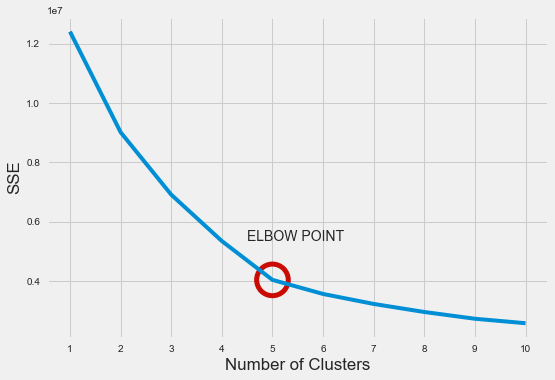

In [109]:
# WE PLOT THE SSE VALUES
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.scatter(5,SSE[4], marker='o', facecolors='none', edgecolors='r',s=1000, linewidth=5)
plt.annotate('ELBOW POINT',(4.5,sse[3]))
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

+ The above plot show the $SSE$ as a function of the number of clusters, note that $SSE$  values continues to decrease as $k$ increases. As more centroids are added, the distance from each point to the nearest centroid will decrease.<br>There is a point at which the $SSE$ curve begins to bend, it is known as the **elbow point**. The value of this point is considered to be a reasonable trade-off between error and number of clusters. In our case this point is **5**.

#### **Calinski-Harabasz index**

In [98]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42, }

CH=[]

for k in range(2, 11):
    
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    clusters_label = kmeans.fit_predict(principalDf)  
        
    # WE STORE IN A LIST THE CALINSKI-HARABASZ INDEX VALUES FOR THE DIFFERENT k
    CH.append(sklearn.metrics.calinski_harabasz_score(principalDf, np.array(clusters_label)))

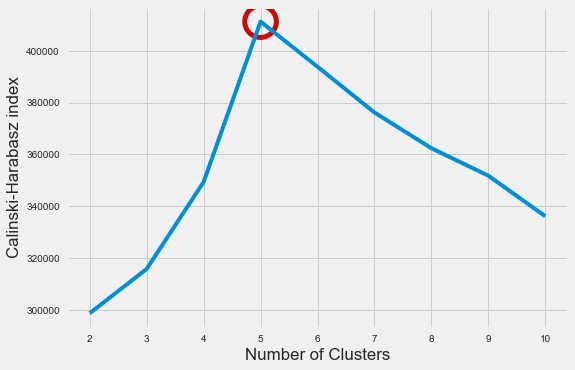

In [99]:
# WE PLOT THE CALINSKI-HARABASZ INDEX VALUES
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), CH)
plt.scatter(5,CH[3], marker='o', facecolors='none', edgecolors='r',s=1000, linewidth=5)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz index")
plt.show()

* The **Calinski-Harabasz index** qualitative is the ratio of the sum of inter-cluster dispersion and the sum of intra-cluster dispersion for all clusters (where the dispersion is the sum of squared distances) . 
    - Formally:
    <br><br>
    $
    \begin{align}
    d_{INTER}= \sum_{k=1}^K n_k \dot || C_k -C ||^2 \qquad \text{(inter-cluster dispersion)}
    \end{align}
    $
    <br><br>
    Where $K$ is the number of clusters, $C$ is the centroid of the dataset (barycenter), $n_k$ is the number of observations contained in the cluster $k$ and $C_k$ is its centroids. So we have 
    <br><br>
    $
    \begin{align}
    CH = \quad \frac{d_{INTER}}{d_{INTRA}}\cdot \frac{N-K}{K-1} \quad = \quad \frac{d_{INTER}}{SSE}\cdot \frac{N-K}{K-1}
    \end{align}
    $
    <br><br>
    Where $SSE$ it's the same defined above for the **Elbow method** and  N is the total number of observations.
    - From the above formula, we can conclude that the large values of **Calinski-Harabasz index** represent better clustering because they correspond to clusters with all the points close to each other or distant centroids or both the conditions so that there are well-marked boundaries between the various clusters.<br> In our case in **5** there is the highest values.



*

#### **Davies-Bouldin Index**

In [66]:
DB = []

for i in range(2,11):
    
    kmeans = KMeans(n_clusters=i, random_state=30)
    clusters_label = kmeans.fit_predict(principalDf)
    
    # WE STORE IN A LIST THE DAVIES-BOULDIN INDEX VALUES FOR THE DIFFERENT k
    DB.append(davies_bouldin_score(principalDf, clusters_label))

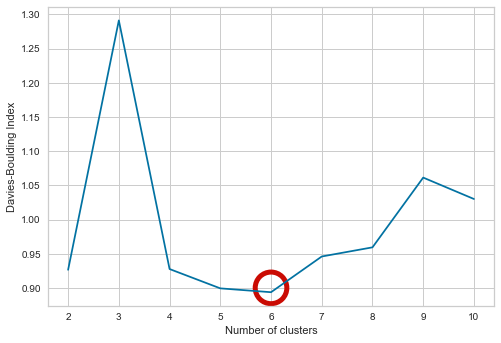

In [68]:
# WE PLOT THE DAVIES-BOULDIN INDEX VALUES
plt.plot(range(2, 11), DB)
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.scatter(6, DB[4] , marker='o', facecolors='none', edgecolors='r',s=1000, linewidth=5)
plt.show()

* The **Davies-Bouldin index**, without going into details, is defined as the average measure of similarity of each cluster to its most similar cluster, where similarity is the ratio of distances within the cluster to distances between clusters, more distant and less dispersed clusters will result in a better score. A low score means a good number of clusters. **6** then would be the best choice

* In conclusion **5** is the number recommended by the **elbow method** and the **Calinski-Harabansz index**, and this will'be our choice as *natural number of cluster*, indeed 5 is the second lowest score for the **Davies-Bouldin index** after 6.

### **2.3.3 / 2.3.4: Application to data**

+ Let's apply our function `K_means` to data and compare the result with those returns by the function `KMeans` of the sklearn library. This last function compute the clusters with the **K-means++** procedure that differs from the **K-means** initializing the centroids so that they are, generally, far apart, leading to arguably better results than random initialization. In fact in the random way the risk is that the initial centroid are close and that the clusters are not very good.<br> In the following ,for what is said ,we will refer to the `KMeans` function with the label `K-Means++`.

#### **First comparison**

In [101]:
k=5

np.random.seed(1234)

# WE CHOOSE 5 RANDOM INTIAL CENTROIDS
random_intial_centroids=principalDf.sample(n=5).copy(deep=True)
random_intial_centroids.index=[i for i in range(1,k+1)]

# WE CALL OUR IMPLEMENTATION
clusters_1_scratch, centroids_1_scratch, SSE_1_scratch = K_means(principalDf, 100, random_intial_centroids, 0.05)

In [102]:
model = KMeans(init="k-means++", n_clusters = k)
clusters_sklearn = model.fit_predict(principalDf)

+ To get clearer visualizations before displaying the results we index each cluster returned by the `KMeans` function with the same index as the cluster with which it shares more elements produced by the `K_means` function.

In [103]:
clusters_sklearn_series = pd.Series(clusters_sklearn)

indexes_sklearn=[]
indexes_scratch_1=[]

for i in range(k):
    indexes_sklearn.append(clusters_sklearn_series[clusters_sklearn_series == i].index)
    indexes_scratch_1.append(clusters_1_scratch[clusters_1_scratch == i+1].index)  

# WE INITIALIZE THE SERIES WHERE WILL BE STORED THE NEW INDEXES    
clusters_match_1=pd.Series(np.zeros(principalDf.shape[0]))    
    
for j in range(k):
    intersection_j = [len(indexes_sklearn[j].intersection(indexes_scratch[i])) for i in range(k)]
    clusters_match_1[clusters_sklearn_series == j] = intersection_j.index(max(intersection_j))+1

+ Here some plots of the results, in order to see the difference in the clusters obtained with the two function.<br> In particular we consider pairs of principal components reffering to the data and represent the points by relating to them. We had to represent in 2 dimensions because the whole thing is easier to visualize than the 4 dimensions. Of all the possible combinations of *Principal Components*, we chose these three:(PC1,PC2); (PC3,PC4); (PC1,PC4).

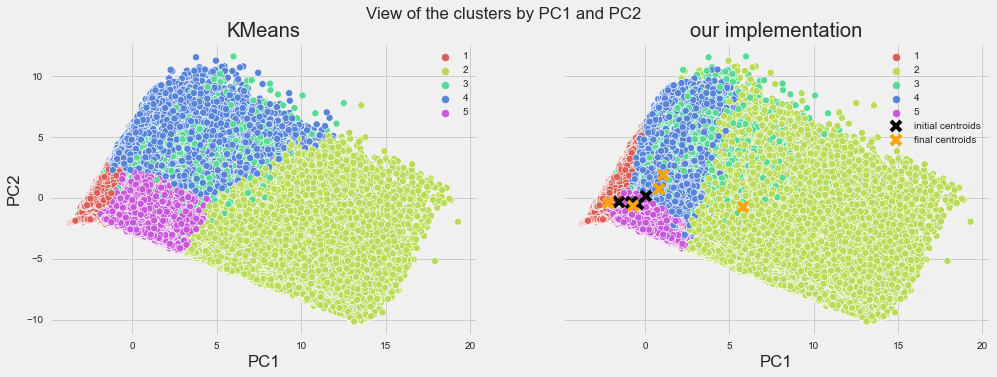

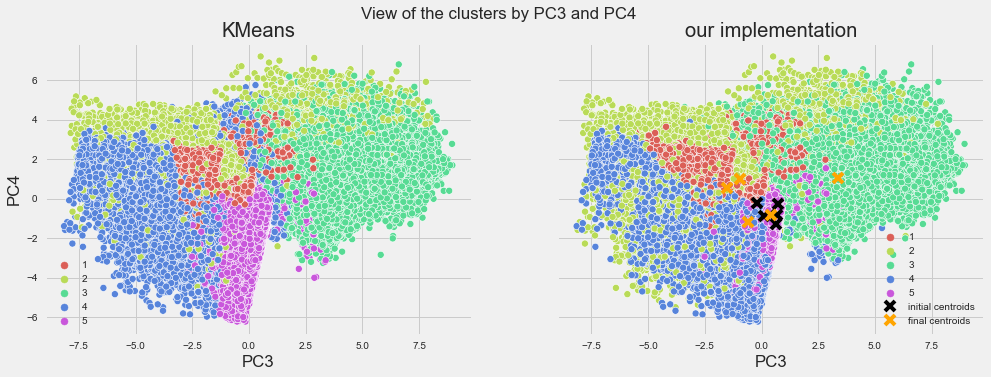

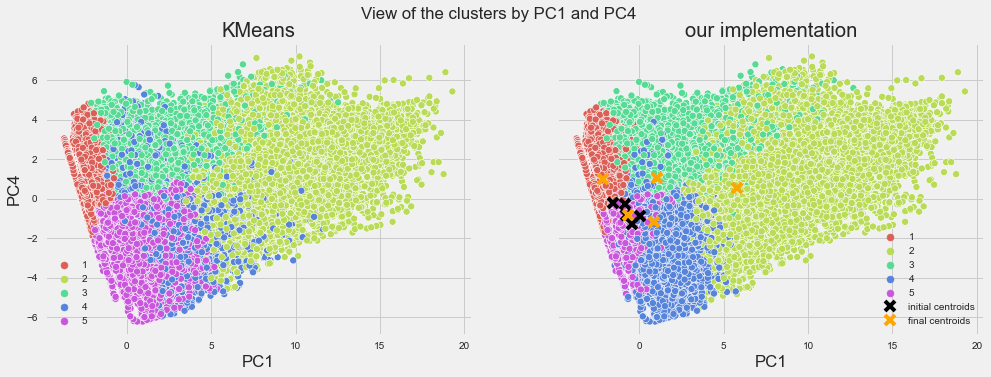

In [104]:
PC_list =[('PC1','PC2'),('PC3','PC4'),('PC1','PC4')]

for pair in PC_list:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    fig.suptitle('View of the clusters by '+ pair[0]+' and '+ pair[1])
    
    # KMeans result
    sns.scatterplot(ax=axes[0],x = principalDf[pair[0]], y = principalDf[pair[1]],
                    palette = sns.color_palette("hls", k),
                    hue = np.array(clusters_match_1,dtype=int) , s=50)
    axes[0].set_title('KMeans')
    axes[0].legend(loc=0)

    # K_means result
    sns.scatterplot(ax=axes[1],x = principalDf[pair[0]], y = principalDf[pair[1]],
                    palette = sns.color_palette("hls", k),
                    hue = (clusters_1_scratch) , s=50)

    axes[1].plot(np.array(list(random_intial_centroids[pair[0]].values)),np.array(list(random_intial_centroids[pair[1]].values)), 'x', color='black', mew=4 ,ms=10, label='initial centroids')
    axes[1].plot(np.array(list(centroids_1_scratch[pair[0]].values)),np.array(list(centroids_1_scratch[pair[1]].values)), 'x', color='white',markeredgecolor='orange', mew=4 ,ms=10, label='final centroids')
    axes[1].set_title('our implementation')
    axes[1].legend(loc=0)

+ In the right plots, the crosses show the initial random centroids given to `K_means` (<span style="color:black">X</span>), which for each component considered seem very close to each other, and those obtained at the end of the process (<span style="color:orange">X</span>) and we observe how these remain near the start location (accordinding to the various components considered) for some clusters and for others they do not. Looking at the three comparisons shown, except for the cluster $3$ (<span style="color:green">■</span>), we note differences between the  clusters returned by `KMeans` and the other ones returned by `K_means` in the latter it is observed visually:
   - (PC1-PC2) &rarr; cluster $2$ (<span style="color:yellow">■</span>)  prevails over cluster $4$ (<span style="color:blue">■</span>); cluster $4$ (<span style="color:blue">■</span>)  prevails over cluster $5$ (<span style="color:purple">■</span>)
   - (PC3-PC4)  &rarr; reduction of cluster $5$ (<span style="color:purple">■</span>)  and cluster $4$ (<span style="color:blue">■</span>)
   - (PC1-PC4)  &rarr; cluster $4 $(<span style="color:blue">■</span>)  prevails over cluster $5$ (<span style="color:purple">■</span>)


+ Quantitative differences:

In [105]:
cluster_difference_1=pd.DataFrame(np.zeros((k,3)), index=['cluster'+str(i) for i in range(1,k+1)] , columns=['common_point','K-Means++','K_means',])

indexes_match_1=[]

for j in range(1,k+1):
    indexes_match_1.append(clusters_match_1[clusters_match_1 == j].index)    

for i in range(k):
    cluster_difference_1.iloc[i]=np.array([len(indexes_match_1[i].intersection(indexes_scratch_1[i])),len(indexes_match_1[i]),len(indexes_scratch_1[i])],dtype=int)

cluster_difference_1['size_ratio']=round( cluster_difference_1['K_means'].divide(cluster_difference_1['K-Means++']),3)
cluster_difference_1['common in K-Means++ (%)']=round( cluster_difference_1['common_point'].divide(cluster_difference_1['K-Means++']),3) 
cluster_difference_1['common in K_means (%)']=round( cluster_difference_1['common_point'].divide(cluster_difference_1['K_means']),3)

In [106]:
cluster_difference_1

,common_point,K-Means++,K_means,size_ratio,common in K-Means++ (%),common in K_means (%)
cluster1,227335.0,248227.0,234846.0,0.946,0.916,0.968
cluster2,41025.0,41220.0,74037.0,1.796,0.995,0.554
cluster3,95408.0,98226.0,99493.0,1.013,0.971,0.959
cluster4,29917.0,59914.0,159294.0,2.659,0.499,0.188
cluster5,206332.0,347369.0,227286.0,0.654,0.594,0.908


* In `cluster_difference_1` the columns `'K-Means++'` and `'K_means'` represent the total number of points contained in the $j$-$th$ clusters returned by the two functions so called, the column `'common_point'` tells us how many point are shared by this two sets, the columns `'common in K-Means++ (%)'` and `'common in K_means (%)'` are the ratios between the number of common points and the total number of points of the cluster in percent instead the column `'size_ratio'` it's the ratio between the total number of points of the $j$-$th$ clusters where the one relative to `KMeans` is at the denominator. <br> From the last three columns we can see how:
  + the clusters $1$ and the clusters $3$ are almost equal;
  + the clusters $2$ producede by `K-Means++` is contained in the corresponding one produced by `K_means`  but has about the half of the points than it while the situation is the opposite for the cluster $5$;
  + the clusters $4$ are very different

#### **Second comparison**

+ From the way we described **K-means++**, used by `K-means++`, we expect that by giving our implementation `K_means` distant initial centroids the results of the two functions used before should be more similar.<br>We now propose to analyze this case. The below function `Get_initial_centroids` for a given integer `k` returns as many samples from the input dataframe `dataframe` making sure they are not 'too close' to each other.

In [107]:
def Get_initial_centroids(dataframe,k):
    
    # IF REPRODUCIBILITY IS NECESSARY
    np.random.seed(123)
    
    # MEMORY PRE-ALLOCATION
    initial_centroids = pd.DataFrame(np.zeros((k,4)),index=[i for i in range(1,k+1)], columns=['PC1','PC2','PC3','PC4'])

    # WE CHOOSE AS FIRST CENTROID THE AVERAGE POINT OF THE DATA
    initial_centroids.loc[1]=np.array(dataframe.mean()) 

    # LET'S SET THE REMAINS CENTROIDS
    for j in range(2,k+1):
        
        # SUPPORT VARIABLES
        candidate = pd.DataFrame(np.zeros((10,4)) ,columns=['PC1','PC2','PC3','PC4'])
        distance = pd.Series(np.zeros(10))        
        
        # FOR EACH ITERATION WE PICK TEN CANDIDATES FOR THE ROLE OF j-TH CENTROID
        for i in range(10):
            sample = np.array(dataframe.sample(n=1).iloc[0])
            candidate.iloc[i] =sample
            distance.iloc[i]=((((initial_centroids.loc[1:j-1]-sample)**2).sum(axis=1))**(1/2)).min()
        
        # AMONG THE CANDIDATES WE CHOOSE WHICH THE MINIMUM DISTANCE FROM THE VARIOUS CENTROIDS IS MAXIMUM.
        initial_centroids.loc[j]=np.array(candidate.iloc[distance.idxmax()])
    

    return initial_centroids

+ Now we compute again the clusters by exploiting the function `Get_initial_centroids`. 

In [108]:
k=5

# WE SET THE INTIAL CENTROIDS WITH Get_initial_centroids
distant_centroids = Get_initial_centroids(principalDf,k)

# WE CALL OUR IMPLEMENTATION
clusters_2_scratch, centroids_2_scratch, SSE_2_scratch = K_means(principalDf, 100, distant_centroids, 0.05)

+ As before we put the same index to clusters that share more elements.

In [109]:
clusters_sklearn_series = pd.Series(clusters_sklearn)

indexes_sklearn=[]
indexes_scratch_2=[]

for i in range(k):
    indexes_sklearn.append(clusters_sklearn_series[clusters_sklearn_series == i].index)
    indexes_scratch_2.append(clusters_2_scratch[clusters_2_scratch == i+1].index)  

# WE INITIALIZE THE SERIES WHERE WILL BE STORED THE NEW INDEXES    
clusters_match_2=pd.Series(np.zeros(principalDf.shape[0]))    
    
for j in range(k):
    intersection_j = [len(indexes_sklearn[j].intersection(indexes_scratch_2[i])) for i in range(k)]
    clusters_match_2[clusters_sklearn_series == j] = intersection_j.index(max(intersection_j))+1

+ We plot the result.

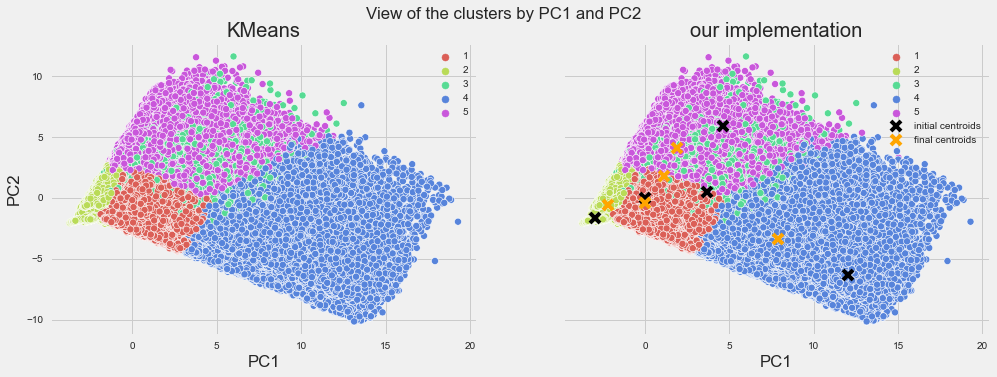

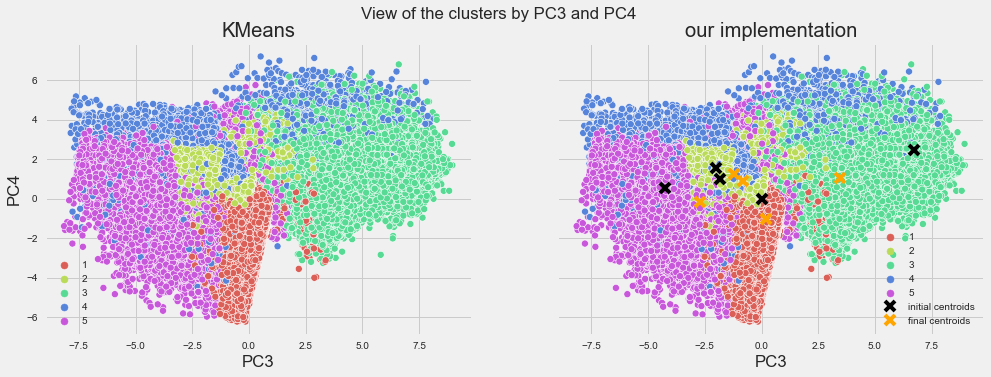

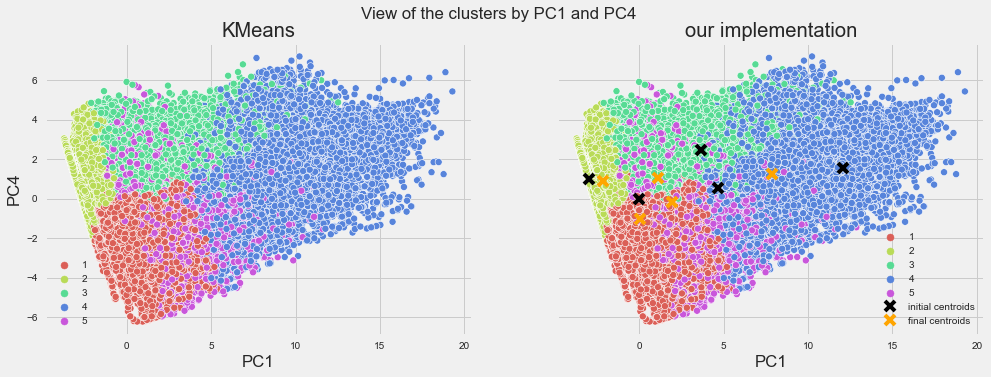

In [110]:
PC_list =[('PC1','PC2'),('PC3','PC4'),('PC1','PC4')]

for pair in PC_list:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    fig.suptitle('View of the clusters by '+ pair[0]+' and '+ pair[1])
    
    # KMeans result
    sns.scatterplot(ax=axes[0],x = principalDf[pair[0]], y = principalDf[pair[1]],
                    palette = sns.color_palette("hls", k),
                    hue = np.array(clusters_match_2,dtype=int) , s=50)
    axes[0].set_title('KMeans')
    axes[0].legend(loc=0)

    # K_means result
    sns.scatterplot(ax=axes[1],x = principalDf[pair[0]], y = principalDf[pair[1]],
                    palette = sns.color_palette("hls", k),
                    hue = (clusters_2_scratch) , s=50)

    axes[1].plot(np.array(list(distant_centroids[pair[0]].values)),np.array(list(distant_centroids[pair[1]].values)), 'x', color='black', mew=4 ,ms=10, label='initial centroids')
    axes[1].plot(np.array(list(centroids_2_scratch[pair[0]].values)),np.array(list(centroids_2_scratch[pair[1]].values)), 'x', color='white',markeredgecolor='orange', mew=4 ,ms=10, label='final centroids')
    axes[1].set_title('our implementation')
    axes[1].legend(loc=0)

+ It is evident from the graphs that with the expedient implemented in `Get_initial_centroids`, i.e. taking distant initial centroids, the clusters obtained from the two functions are practically the same visually.

+ quantitative differences:

In [111]:
cluster_difference_2=pd.DataFrame(np.zeros((k,3)), index=['cluster'+str(i) for i in range(1,k+1)] , columns=['common_point','KMeans','K_means',])

indexes_match_2=[]

for j in range(1,k+1):
    indexes_match_2.append(clusters_match_2[clusters_match_2 == j].index)    

for i in range(k):
    cluster_difference_2.iloc[i]=np.array([len(indexes_match_2[i].intersection(indexes_scratch_2[i])),len(indexes_match_2[i]),len(indexes_scratch_2[i])],dtype=int)

cluster_difference_2['size_ratio']=round( cluster_difference_2['K_means'].divide(cluster_difference_2['KMeans']),3)   
cluster_difference_2['common in KMeans (%)']=round( cluster_difference_2['common_point'].divide(cluster_difference_2['KMeans']),3) 
cluster_difference_2['common in K_means (%)']=round( cluster_difference_2['common_point'].divide(cluster_difference_2['K_means']),3)  

In [112]:
cluster_difference_2

,common_point,KMeans,K_means,size_ratio,common in KMeans (%),common in K_means (%)
cluster1,347359.0,347369.0,358028.0,1.031,1.000,0.970
cluster2,243884.0,248227.0,244781.0,0.986,0.983,0.996
cluster3,95845.0,98226.0,96224.0,0.980,0.976,0.996
cluster4,39775.0,41220.0,39775.0,0.965,0.965,1.000
cluster5,55968.0,59914.0,56148.0,0.937,0.934,0.997


+ How we expected from the hypothesis made at the beggining of this second comparison and the previous plots, the two functions in this case return pretty much the same clusters. 

#### **Each Cluster is made of bank'customers !**

* Lets now go to see how the bank's customers came to be grouped in the graph.<br> We plot here again the clusters returbd by `K-Means++` so that they can be commented on.

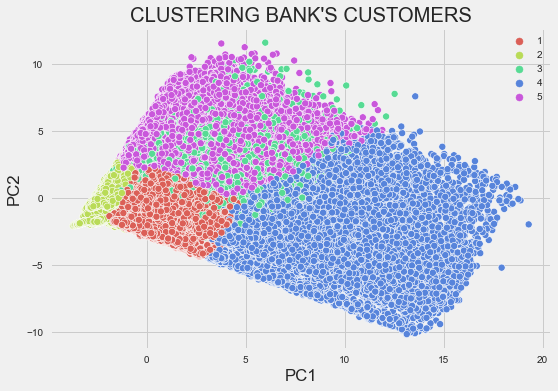

In [116]:
pair =('PC1','PC2')

sns.scatterplot(x = principalDf[pair[0]], y = principalDf[pair[1]],
            palette = sns.color_palette("hls", k),
            hue = np.array(clusters_match_2,dtype=int) , s=50)

plt.ylabel(pair[1])
plt.xlabel(pair[0])
plt.title('CLUSTERING BANK\'S CUSTOMERS')
plt.legend(loc=0)

* Looking at the graph you can see the placement of the units with respect to the first two principal components:
    - Cluster $3$ has fairly scattered units; consequently, this cluster is not very dependent on the first two principal components.

    - Cluster $1$ contains units that have values of the first and second principal components close to the origin. Given the origin the mean value of the first and second principal components, and given that the first component is especially correlated with the mean, maximum, and minimum values of balance and utilization, while the second component is especially correlated with the mean, total, maximum, and minimum values of transactions, it can be assumed that the units in this cluster have values close to the mean in these variables.

    - Cluster $2$ being shifted slightly to the left will have lower values on average (mean values of the first and principal component concur with the origin) than the balance and utilisation (being the variables most correlated with the first principal component).

    - cluster $5$ will present higher values on average of the first and second principal component.

    - cluster $4$ will present lower values on average of the second principal component and higher values on average of the first principal component.

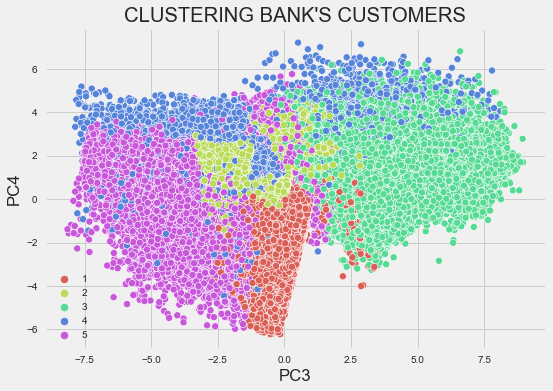

In [117]:
pair =('PC3','PC4')

sns.scatterplot(x = principalDf[pair[0]], y = principalDf[pair[1]],
            palette = sns.color_palette("hls", k),
            hue = np.array(clusters_match_2,dtype=int) , s=50)

plt.ylabel(pair[1])
plt.xlabel(pair[0])
plt.title('CLUSTERING BANK\'S CUSTOMERS')
plt.legend(loc=0)

* From the graph depicting the units with respect to the third and fourth principal components we observe:
    - cluster $3$: the units have higher values on average than the third main component (remember that the average value of the third component is the x-axis equals 0). Since the 3 CP correlated more with Utilisation<1000, num_transaction and time(day), it is assumed that units with above-average values in these variables will be present in this cluster.

    - cluster $1$: below-average values for the fourth principal component.

    - cluster $2$: average values for the third and fourth principal components.

    - cluster $5$: lower average values for the third principal component.

    - cluster $4$: higher average values for the fourth principal component.

## **2.4 Analysing your results!**

### **2.4.1 Identify the cluster** 

* Let's take the features that are more correlated with every **PCA** because probably they are the more relevant to identify each cluster: we will take `Costumer Age Min`, `Utilisation<1000`, `Total_transaction`.

### **2.4.2 Categories**

In [18]:
clients_cat = clients_final

#### **CustomerAge_min**

* The first feature we are going to work on is `CustomerAge_min`, which is to consider the smallest age of customers for each bank account. We will divide it into the following 4 categories, to do this we are going to look the quartile (each interval between the values into which a data set is divided, corresponding to a quarter of the cases collected).

In [74]:
clients_final.CustomerAge_min.quantile([0.25,0.5,0.75])

0.25    25.0
0.50    28.0
0.75    33.0
Name: CustomerAge_min, dtype: float64

* The first quartile is in 25, the second (the median) is in 28, the third quartile is in 33, so we are going to make 4 categories in this way:
  1. age < 25
  2. age between 25 and 28
  3. age between 28 and 33
  4. age > 33


In [83]:
clients_cat['CustomerAge_min_c'] = pd.qcut(clients_final.CustomerAge_min, q = 4, labels=['-25', '25-28', '28-33', "33+"])

#### **Utilisation<1000**

* Let us now consider the feature `utilisation<1000`, the variable that tells me how many utilisations are less than 1000 for each transaction in a bank account. We will consider cases where this value is equal to 0,1,2,3.

In [20]:
clients_cat["Utilisation<1000_c"] = pd.cut(clients_final["Utilisation<1000"], bins = [-1,0,1,2,3], labels=['0', '1', '2', "3"])

#### **Total_transactions**

* The categories we create instead for the `Total_transactions` feature (i.e., the total amount of transactions for a customer), are:
   1. total <= 1000

   2. 1000 < total <= 2000

   3. 2000 < total <= 3000

   4. total > 3001

In [94]:
clients_cat["Total_transactions_c"] = pd.cut(clients_final["Total_transactions"], bins = [0,1000,2000,3000,10000000], labels=['<1000', '1000-2000', '2000-3000', "+3000"])

### **2.4.3 Pivot table**

In [44]:
clusters = np.array(clusters_match_2, dtype = int)

#### **CustomerAge_min**

In [84]:
table = pd.crosstab(clusters, clients_cat['CustomerAge_min_c'], margins=True, margins_name="Total")
table

CustomerAge_min_c,-25,25-28,28-33,33+,Total
row_0,,,,,
1,80260,70607,85640,110789,347296
2,106297,60817,54715,26376,248205
3,49071,25576,17377,6198,98222
4,4852,6453,10414,19480,41199
5,9910,9995,14533,25596,60034
Total,250390,173448,182679,188439,794956


#### **Utilisation<1000**

In [53]:
table = pd.crosstab(clusters, clients_cat["Utilisation<1000_c"], margins=True, margins_name="Total")
table

Utilisation<1000_c,0,1,2,3,Total
row_0,,,,,
1,477,345416,1403,0,347296
2,97395,149967,843,0,248205
3,221,18747,71780,7474,98222
4,0,37995,3058,146,41199
5,9980,48348,1705,1,60034
Total,108073,600473,78789,7621,794956


#### Total_transactions

In [95]:
table = pd.crosstab(clusters, clients_cat["Total_transactions_c"], margins=True, margins_name="Total")
table

Total_transactions_c,<1000,1000-2000,2000-3000,+3000,Total
row_0,,,,,
1,279091,58518,9411,7,347027
2,217972,24586,5260,183,248001
3,40120,27337,14193,16572,98222
4,22813,9047,4571,4739,41170
5,0,241,17574,42219,60034
Total,559996,119729,51009,63720,794454


### **2.4.4 /2.4.5: percentage by column for each pivot table and results**

#### **CustomerAge_min**

In [85]:
table = pd.crosstab(clusters, clients_cat['CustomerAge_min_c'] ).round(2)
table.apply(lambda x: x*100/sum(x),axis = 1).round(2)

CustomerAge_min_c,-25,25-28,28-33,33+
row_0,,,,
1,23.11,20.33,24.66,31.90
2,42.83,24.50,22.04,10.63
3,49.96,26.04,17.69,6.31
4,11.78,15.66,25.28,47.28
5,16.51,16.65,24.21,42.64


* Clusters $2$ and $3$ mainly present the bank accounts with the youngest minimum age customers (i.e., under 25 years old), with as much as 42.83 percent for cluster $2$ and 49.96 percent for cluster $3$. <br> Clusters $4$ and $5$ are characterized by a strong presence of more adult clients. In fact, the lowest age here is for as many as 47.28% of clients in cluster $4$ and 42.64% of clients in cluster $5$ at an age greater than or equal to 33.<br> Cluster $1$ has fairly distributed values of the minimum ages and thus is not particularly characterized by this variable.

In [61]:
table = pd.crosstab(clients_cat['CustomerAge_min_c'], clusters ).round(2)
table.apply(lambda x: x*100/sum(x),axis = 0).round(2)

col_0,1,2,3,4,5
CustomerAge_min_c,,,,,
young,0.20,0.60,0.73,0.17,0.27
young adult,54.91,77.87,85.29,38.59,43.51
adult,40.73,21.03,13.88,51.74,48.61
old,4.16,0.49,0.10,9.50,7.61


#### **Utilisation<1000**

In [89]:
table = pd.crosstab(clusters, clients_cat["Utilisation<1000_c"]).round(2)*100
table.apply(lambda x: x*100/sum(x),axis = 1).round(2)

Utilisation<1000_c,0,1,2,3
row_0,,,,
1,0.14,99.46,0.40,0.00
2,39.24,60.42,0.34,0.00
3,0.23,19.09,73.08,7.61
4,0.00,92.22,7.42,0.35
5,16.62,80.53,2.84,0.00


* The clusters are highly characterized by the variable `Utilisation<1000`, in fact it is visible how much the distribution of customers in the different clusters occurred according to their membership in the different categories of the `Utilisation<1000`.<br> In cluster $1$, 99.46% of bank accounts have a value for utilisation<1000 equal to 1. A very high value for this category is also present in cluster $4$ (92.22%) and cluster $5$ (80.53%).<br> Cluster $2$, on the other hand, presents a value of 60.42% at "1" but also a high value for "0" (39.24%), so there are many bank accounts in this cluster that in the difference between balance and transaction amount have never presented values below 1000, so these customers have never made large expenditures with respect to their balance.<br> Cluster $3$, on the other hand, has a high value for category 2 (73.08%), so there are many customers here who made very high transactions (relative to their balance), such that their utilization was under a thousand 2 times.

#### **Total_transactions**

In [96]:
table = pd.crosstab(clusters, clients_cat["Total_transactions_c"]).round(2)*100
table.apply(lambda x: x*100/sum(x),axis = 1).round(2)

Total_transactions_c,<1000,1000-2000,2000-3000,+3000
row_0,,,,
1,80.42,16.86,2.71,0.00
2,87.89,9.91,2.12,0.07
3,40.85,27.83,14.45,16.87
4,55.41,21.97,11.10,11.51
5,0.00,0.40,29.27,70.33


* Clusters also tell the total_transactions variable well.<br> Cluster $5$ is the group that mainly contains customers who made a total number of transactions greater than 3000 (70.33%).<br> Clusters $1$ and $2$, on the other hand, contain mainly those customers who made a total of transactions less than 1000: cluster $1$ has 80.42% of customers in this category, cluster $2$ has 87.89%.<br> Clusters $3$ and $4$ do not have such pronounced values for any category although there are always mostly low values of total transaction.

### **2.4.6: Clustering algorithm performance**

* To estimate clustering algorithm performance we can draw heavily on the methods used to choose the optimal number of clusters, namely the **elbow method**, the **Calinski-Harabasz index** and the **Davies-Bouldin Index**. These methods rated 5 well as the optimal number of clusters to choose, consequently we can say that the performance of our clustering is good.